In [1]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
from cv.supervised import GaussPerceptron

Спочатку завантажимо у пам'ять наші вибірки та зобразимо їх на графіках. Зауважу, що попередньо я вже трансфорував дані з формату `json` у формат `npy`

In [2]:
data1 = jnp.load('train1.npy')
data2 = jnp.load('train2.npy')

Розділимо мітки класів та фічі.

In [3]:
X1 = data1[:, :-1]
Y1 = data1[:, -1]

X2 = data2[:, :-1]
Y2 = data2[:, -1]

Поглянемо на перший датасет

In [4]:
def plot_dataset(X, Y):
    plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], label='outside')
    plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], label='inside')
    plt.legend()

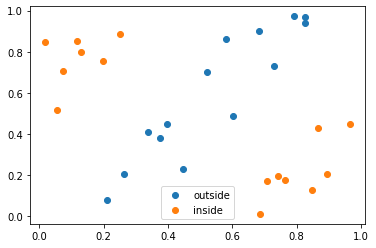

In [5]:
plot_dataset(X1, Y1)

Зобразимо на графіку 2 датасет

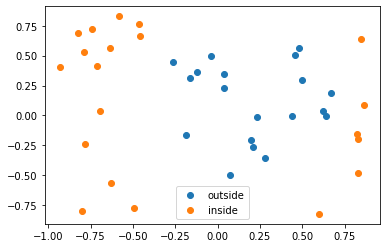

In [6]:
plot_dataset(X2, Y2)

Завдання полягає у тому, що на базі персептрона треба розробити алгоритм
оцінки параметрів нормального розводілу та порового значення 
за наявності емпіричного матеріалу $T \in (R^n \times \{ \pm 1 \})^m$, для якого точно відомо, 
що існують такі $\Sigma$(матриця коваріацій), $\mu$(середнє) та $\theta$(порогове значення).

Запишемо функцію щільності нормального розподілу
$$ p(x) = \frac{1}{\sqrt{(2\pi)^n \det \Sigma}} \exp\left\{-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) \right\} > \theta $$

Прогогарифмуємо цей вираз
$$ -\frac{1}{2} \ln \left[(2\pi)^n \det \Sigma \right] - \frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu) - \ln \theta > 0 $$

Помножимо на -2 та розпишемо за білінійністю квадратичну форму
$$ (x-\mu)^T \Sigma^{-1} (x-\mu) + \ln \left[(2\pi)^n \det \Sigma \right] + 2 \ln \theta < 0 $$
$$ x^T \Sigma^{-1} x - 2 \mu^T \Sigma^{-1} x + \mu^T \Sigma^{-1} \mu + \ln \left[(2\pi)^n \det \Sigma \right] + 2 \ln \theta < 0 $$

Перепозначимо деякі величини:
$$ \eta = -2 \mu^T \Sigma^{-1} \implies \mu = -\frac{\eta \Sigma}{2} $$
$$ c =  \mu^T \Sigma^{-1} \mu + \ln \left[(2\pi)^n \det \Sigma \right] + 2 \ln \theta \implies
\theta = \frac{1}{\sqrt{(2\pi)^n \det \Sigma}} \exp \left\{ \frac{c - \mu^T \Sigma^{-1} \mu}{2}  \right\} $$

Таким чином маємо наступне
$$ \sum\limits_{i,j=1}^{n} x_i \sigma_{i,j} x_j + \sum\limits_{i=1}^{n} \eta_i x_i + c < 0 $$

Відповідно, наша задача зводиться до такої, яку може розв'язати персептрон, якщо ми наступним чином трансформуємо наш емпіричний матеріал і оберемо такий вигляд "вектора вагів"
$$ 
\varphi(x) = \begin{pmatrix}
    x_1x_1 \\
    x_1x_2 \\
    \vdots \\
    x_nx_n \\
    x_1 \\
    \vdots \\
    x_n \\
    1
\end{pmatrix} 
\hspace{1cm}
\omega = \begin{pmatrix}
    \sigma_{11}^{-1} \\
    \sigma_{12}^{-1} \\
    \vdots \\
    \sigma_{nn}^{-1} \\
    \eta_1 \\
    \vdots \\
    \eta_n \\
    c
\end{pmatrix}
\hspace{1cm}
\varphi(x)^T\omega < 0
$$

Як ми бачимо, знак нерівності змінився, тому ми повинні змінити й мітки наших класів

In [7]:
Y1 = -Y1
Y2 = -Y2

Але як ми усі чудово знаємо, алгоритм навчання персептрона не гарантує, що значення $\omega$ будуть такими, що
задовольняють ті умови, що ми накладаємо на матрицю коваріацій. Тож з цим треба щось зробити.

Відомо, що для кожної симетричної матриці існує спектральний розклад($\lambda_i$ - i-те власне число, $v_i$ - вектор, що відповідає i-тому власному числу):
$$ 
\begin{pmatrix}
    v_1
    \dots
    v_n
\end{pmatrix}
\begin{pmatrix}    
    \lambda_1 & & \\
    & \vdots & \\
    & & \lambda_n
\end{pmatrix}
\begin{pmatrix}
    v_1 \\
    \vdots \\
    v_n
\end{pmatrix}
$$

Відповідно обернена матриця(якщо існує) обчислюється дуже просто:
$$ 
\begin{pmatrix}
    v_1
    \dots
    v_n
\end{pmatrix}
\begin{pmatrix}
    \frac{1}{\lambda_1} & & \\
    & \vdots & \\
    & & \frac{1}{\lambda_n}
\end{pmatrix}
\begin{pmatrix}
    v_1 \\
    \vdots \\
    v_n
\end{pmatrix}
$$

Помітимо, що має місце за умови, що вектор $v_i \neq 0$
$$ \lambda_i > 0 \iff v_i^T \Sigma^{-1} v_i = v_i^T \lambda_i v_i = ||v_i||^2 \lambda_i > 0 $$ 

А отже, властивість додатньої визначеності, у такому разі, можна сформулювати як те, що кожне власне число більше нуля, а отже якщо обернена матриця додатньо визначена, то і сама матриця має таку властивість. Ми, під час роботи алгоритму, оперуємо елементами оберненої матриці до матриці коваріацій, а отже повинні гарантувати, що перші $n^2$ компонент вектора $w$ утворюють додатньо визначену матрицю. Тому будемо просто додавати з міткою классу +1 до нашого навчального матеріалу вектори
$ (v^{i}_{1}v^{i}_{1}, v^{i}_{1}v^{i}_{2}, \dots, v^{i}_{n}v^{i}_{n}, \underbrace{0, \dots, 0}_{n+1}) $

Зазначу також, що достатньо додати лише один власний вектор з недодатнім власним значення, бо ті, у які відповідають додатнім власним числам і так вже задовольняють умову. А додавання більше одного з недодатнім власним числом не має сенсу, бо після першої ж коррекції треба буде обраховувати власні числа наново, бо зміниться вектор $\omega$ з якого ми і будуємо матрицю $\Sigma^{-1}$

Також напишемо корисні функції для обрахунку щільності нормально розподілу та зображення результатів навчання наших персептронів

In [8]:
def pdf(X, K, m):
    n = X.shape[-1]
    v = X - m
    res = jnp.exp(-0.5 * jnp.einsum('...i,ij,...j', v, jnp.linalg.inv(K), v))
    res = res / jnp.sqrt((2*jnp.pi)**n * jnp.linalg.det(K))
    return res

In [9]:
def plot_with_pdf(gp, X, Y, x_bounds, y_bounds):
    x1, x2 = x_bounds
    y1, y2 = y_bounds

    K, n, theta = gp.learned_parameters

    x, y = jnp.mgrid[x1:x2:.01, y1:y2:.01]
    points = jnp.dstack((x, y))
    density = pdf(points, K, n)

    c = plt.contourf(x, y, density)
    plt.colorbar(c)
    plt.contour(x, y, density, levels=[theta], colors='white', linestyles='dashed')

    plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], c='white')
    plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], c='red')
    plt.scatter(n[0], n[2], marker='*', c='green')

Навчимо запропонавану модель на 1 датасеті

In [10]:
gp1 = GaussPerceptron()
gp1.fit(X1, Y1)

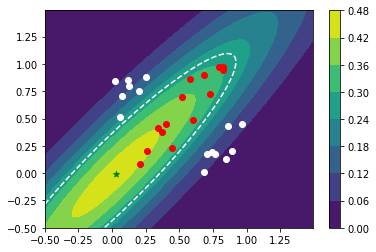

In [11]:
plot_with_pdf(gp1, X1, Y1, [-0.5,1.5], [-0.5,1.5])

І на сам кінець, навчимо модифікований персептрон на 2 датасеті.

In [12]:
gp2 = GaussPerceptron()
gp2.fit(X2, Y2)

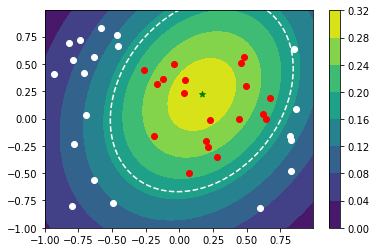

In [13]:
plot_with_pdf(gp2, X2, Y2, [-1,1], [-1,1])